In [1]:
import pandas as pd 
import pymysql
from datetime import datetime
from datetime import timedelta
import plotly.express as px
from RDS_connection import db, user, password
from mod_streamer_data import add_local_time, get_streams, remove_launch_stream_viewership, get_stream_schedule
from datetime import datetime
from dateutil import tz
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
pd.options.mode.chained_assignment = None 

In [2]:
game_id = 512710 #warzone
#game_id = 33214 #fortnite
#game_id = 510218 #among us

In [3]:
'''case
    when Streams.StreamTitle like '%tourn%' or Streams.StreamTitle like '%Tourn%' then 1
    else 0
end Tournament
case
    when Streams.StreamTitle like '%cup%' or Streams.StreamTitle like '%Cup%' then 1
    else 0
end Cup
, case
    when Streams.StreamTitle like '%scrims%' or Streams.StreamTitle like '%Scrims%' then 1
    else 0
end Scrims
, case
    when Streams.StreamTitle like '%wager%' or Streams.StreamTitle like '%Wager%' then 1
    else 0
end Wagers 
, case
    when Streams.StreamTitle like '%arena%' or Streams.StreamTitle like '%Arena%' then 1
    else 0
end Arena

'''

"case\n    when Streams.StreamTitle like '%tourn%' or Streams.StreamTitle like '%Tourn%' then 1\n    else 0\nend Tournament\ncase\n    when Streams.StreamTitle like '%cup%' or Streams.StreamTitle like '%Cup%' then 1\n    else 0\nend Cup\n, case\n    when Streams.StreamTitle like '%scrims%' or Streams.StreamTitle like '%Scrims%' then 1\n    else 0\nend Scrims\n, case\n    when Streams.StreamTitle like '%wager%' or Streams.StreamTitle like '%Wager%' then 1\n    else 0\nend Wagers \n, case\n    when Streams.StreamTitle like '%arena%' or Streams.StreamTitle like '%Arena%' then 1\n    else 0\nend Arena\n\n"

In [4]:
db1 = pymysql.connect(db, user, password)
cursor = db1.cursor()

sql = '''use Streams'''
cursor.execute(sql)

query = f'''
SELECT *

FROM Streams
WHERE Streams.CurrentGameID = {game_id} 
'''

df_competitors = pd.read_sql(query, db1, index_col='ID')

#always run this after use
db1.commit()
cursor.close()
db1.close()

In [5]:
import matplotlib.pyplot as plt
def plot_feature_importances(model):
    n_features = min(len(model.feature_importances_),20)
    feature_imp = dict(zip(list(X.columns),model.feature_importances_))
    feature_imp = {k: v for k, v in sorted(feature_imp.items(), key=lambda item: item[1],reverse=True)}
    feature_imp = dict(list(feature_imp.items())[:20])
    
    plt.barh(np.arange(n_features), list(feature_imp.values()), align='center')
    plt.yticks(np.arange(n_features),list(feature_imp.keys()))
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.ylim(-1, n_features)

In [6]:
#['scoped','clix','bugha','innocents','nickeh30','stableronaldo_','benjyfishy','mongraal']
#['nickmercs','cloakzy','timthetatman','swagg','tfue','aydan']

In [7]:
#shared_viewership = ['scoped','clix','bugha','innocents','nickeh30','stableronaldo_','benjyfishy','mongraal']
#shared_viewership = ['nickmercs','cloakzy','timthetatman','swagg','tfue','aydan','symfuhny']
shared_viewership = list(df_competitors['Name'].unique())

In [8]:
df_competitors = remove_launch_stream_viewership(df_competitors, minutes_from_stream_start=30, method='drop')

target_streamer = 'nickmercs'
target_streamer_data = df_competitors[df_competitors['Name'] == target_streamer]

target_streamer_data = add_local_time(target_streamer_data, cols_to_be_converted=['TimestampUTC','StarttimeUTC'])

#create dummy columns for each competitor to be overwritten
for name in tqdm(shared_viewership):
    target_streamer_data[name] = [0]*len(target_streamer_data)

100%|██████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 1254.58it/s]


In [9]:
df_competitors = df_competitors[df_competitors['Name'].isin(shared_viewership)]

In [10]:
shared_viewership.remove(target_streamer)

In [11]:
#because I built the database with string dates... oops
conv = []
for i in tqdm(range(len(df_competitors))):
    conv.append(datetime.strptime(df_competitors['TimestampUTC'].iloc[i], '%Y-%m-%d %H:%M:%S'))
df_competitors['TimestampUTC_conv'] = conv

100%|███████████████████████████████████████████████████████████████████████| 581794/581794 [00:10<00:00, 54369.55it/s]


In [12]:
# OVERALL: create temporary window_df with all streamers viewer counts near that instant in time

#get only records within 5 minutes on both sides and then clip out duplicates
    
total_competitor_viewership_inc = []
total_competitor_viewership_exc = []
for i in range(len(target_streamer_data)):
    if i % 5 == 0:
        clear_output(wait=True)
        print(f'{i} / {len(target_streamer_data)}')
    window_start = datetime.strptime(target_streamer_data['TimestampUTC'].iloc[i], '%Y-%m-%d %H:%M:%S') - timedelta(minutes=3)
    window_end = datetime.strptime(target_streamer_data['TimestampUTC'].iloc[i], '%Y-%m-%d %H:%M:%S') + timedelta(minutes=3)
    window_df = df_competitors[df_competitors['TimestampUTC_conv'] > window_start]
    window_df = window_df[window_df['TimestampUTC_conv'] < window_end]

    #make sure all names are unique, since database loads once per 5 minutes, this gets one instance from every streamer in the
    #database that is currently live streaming the game in question
    names = []
    drops = []
    
    for j in range(len(window_df)):
        if window_df['Name'].iloc[j] not in names:
            names.append(window_df['Name'].iloc[j])
        else:
            drops.append(window_df.index[j])
            
    window_df.drop(index=drops, inplace=True)
    
    for name in window_df['Name']:
        target_streamer_data[name].iloc[i] = 1 #window_df[window_df['Name'] == name]['ViewerCount'].iloc[0]
    
    #including target streamer
    total_competitor_viewership_inc.append(window_df['ViewerCount'].sum() + target_streamer_data['ViewerCount'].iloc[i])
    #excluding target streamer
    total_competitor_viewership_exc.append(window_df['ViewerCount'].sum())
    
clear_output(wait=True)
print(f'{len(target_streamer_data)} / {len(target_streamer_data)}')
target_streamer_data['CompetitorViewershipVolumeInclusive'] = total_competitor_viewership_inc
target_streamer_data['CompetitorViewershipVolumeExclusive'] = total_competitor_viewership_exc

2351 / 2351


In [13]:
target_streamer_data

,Name,TimestampUTC,CurrentGameID,StreamTitle,ViewerCount,StarttimeUTC,TimestampUTC_toLocal,StarttimeUTC_toLocal,brookeab,nickmercs,...,elfmind,abokyan,dukeofanukes,slasheral,gubbatv,zotieboy,mattywtf1,csrfps,CompetitorViewershipVolumeInclusive,CompetitorViewershipVolumeExclusive
ID,,,,,,,,,,,,,,,,,,,,,
110,nickmercs,2020-09-24 20:17:37,512710,Fraggin | Code: MFAM | @NICKMERCS,52870,2020-09-24 15:02:48,2020-09-24 15:17:37-05:00,2020-09-24 10:02:48-05:00,1,1,...,0,0,0,0,0,0,0,0,217291,164421
433,nickmercs,2020-09-24 20:22:36,512710,Fraggin | Code: MFAM | @NICKMERCS,51082,2020-09-24 15:02:48,2020-09-24 15:22:36-05:00,2020-09-24 10:02:48-05:00,1,1,...,0,0,0,0,0,0,0,0,214302,163220
759,nickmercs,2020-09-24 20:27:36,512710,Fraggin | Code: MFAM | @NICKMERCS,52391,2020-09-24 15:02:48,2020-09-24 15:27:36-05:00,2020-09-24 10:02:48-05:00,1,1,...,0,0,0,0,0,0,0,0,216752,164361
1091,nickmercs,2020-09-24 20:32:37,512710,Fraggin | Code: MFAM | @NICKMERCS,53528,2020-09-24 15:02:48,2020-09-24 15:32:37-05:00,2020-09-24 10:02:48-05:00,1,1,...,0,0,0,0,0,0,0,0,194514,140986
1423,nickmercs,2020-09-24 20:37:36,512710,Fraggin | Code: MFAM | @NICKMERCS,50096,2020-09-24 15:02:48,2020-09-24 15:37:36-05:00,2020-09-24 10:02:48-05:00,1,1,...,0,0,0,0,0,0,0,0,189640,139544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894207,nickmercs,2020-11-17 21:26:03,512710,Fraggin | Code: MFAM | @NICKMERCS,45860,2020-11-17 16:21:23,2020-11-17 15:26:03-06:00,2020-11-17 10:21:23-06:00,0,1,...,0,0,0,0,0,0,0,0,135054,89194
3894559,nickmercs,2020-11-17 21:31:06,512710,Fraggin | Code: MFAM | @NICKMERCS,47972,2020-11-17 16:21:23,2020-11-17 15:31:06-06:00,2020-11-17 10:21:23-06:00,0,1,...,0,0,0,0,0,0,0,0,138030,90058
3894907,nickmercs,2020-11-17 21:36:03,512710,Fraggin | Code: MFAM | @NICKMERCS,49322,2020-11-17 16:21:23,2020-11-17 15:36:03-06:00,2020-11-17 10:21:23-06:00,0,1,...,0,0,0,0,0,0,0,0,140279,90957


Sum Competitors Viewership Volume


C:\Users\leesc\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='CompetitorViewershipVolumeInclusive', ylabel='Density'>

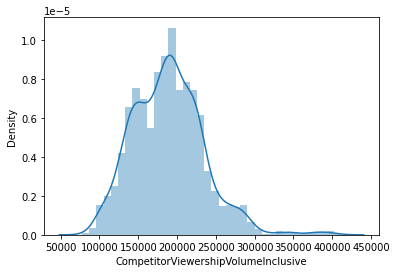

In [15]:
import seaborn as sns
print('Sum Competitors Viewership Volume')
sns.distplot(target_streamer_data['CompetitorViewershipVolumeInclusive'])

nickmercs Viewer Count


C:\Users\leesc\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ViewerCount', ylabel='Density'>

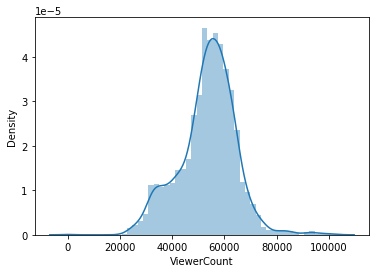

In [16]:
print(f'{target_streamer} Viewer Count')
sns.distplot(target_streamer_data['ViewerCount'])

In [17]:
#removes outliers, these are mostly caused by hosts / raids
mean = target_streamer_data['ViewerCount'].mean()
std = target_streamer_data['ViewerCount'].std()
target_streamer_data = target_streamer_data[target_streamer_data['ViewerCount'] < mean + std*2.5]

nickmercs Viewer Count no Outliers


C:\Users\leesc\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ViewerCount', ylabel='Density'>

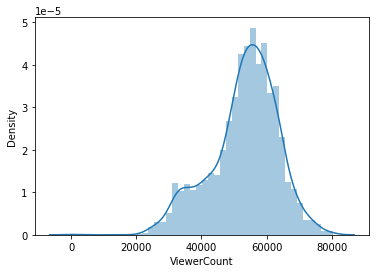

In [18]:
print(f'{target_streamer} Viewer Count no Outliers')
sns.distplot(target_streamer_data['ViewerCount'])

In [19]:
day_of_week_map = {0 : 'Monday', 1 : 'Tuesday', 2 : 'Wednesday', 3 : 'Thursday', 4 : 'Friday', 5 : 'Saturday', 6 : 'Sunday'}
#low = 0, medium = 1, high = 2
std_dev_cut = .7
classify = []
low = target_streamer_data['ViewerCount'].mean() - target_streamer_data['ViewerCount'].std()*std_dev_cut
high = target_streamer_data['ViewerCount'].mean() + target_streamer_data['ViewerCount'].std()*std_dev_cut
print('Classes: \n')
print(f'< {low} = 0')
print(f'{low} < {high} = 1')
print(f'> {high} = 2 \n')
for i in range(len(target_streamer_data['ViewerCount'])):
    if target_streamer_data['ViewerCount'].iloc[i] < target_streamer_data['ViewerCount'].mean() - target_streamer_data['ViewerCount'].std()*std_dev_cut:
        classify.append(0)
    elif target_streamer_data['ViewerCount'].iloc[i] > target_streamer_data['ViewerCount'].mean() + target_streamer_data['ViewerCount'].std()*std_dev_cut:
        classify.append(2)
    else:
        classify.append(1)
target_streamer_data['Target'] = classify

time_of_day = []
hour = []
day_of_week = []
for i in range(len(target_streamer_data)): 
    day_of_week.append(day_of_week_map[target_streamer_data['TimestampUTC_toLocal'].iloc[i].weekday()])
    hour.append(target_streamer_data['TimestampUTC_toLocal'].iloc[i].hour)

target_streamer_data['Hour'] = hour
target_streamer_data['DayOfWeek'] = day_of_week

#random forest needs categorical variable encoded in order by viewership count. DayOfWeek --> DayOfWeekEncoded, Hour --> HourEncoded
hour_map = {}
for hour in list(target_streamer_data['Hour'].unique()):
    hour_map[hour] = target_streamer_data[target_streamer_data['Hour'] == hour]['ViewerCount'].mean()
    hour_map = {k: v for k, v in sorted(hour_map.items(), key=lambda item: item[1])}
for i, hour in enumerate(hour_map.keys()):
    hour_map[hour] = i
target_streamer_data['HourEncoded']= target_streamer_data['Hour'].map(hour_map)

dayofweek_map = {}
for day in list(target_streamer_data['DayOfWeek'].unique()):
    dayofweek_map[day] = target_streamer_data[target_streamer_data['DayOfWeek'] == day]['ViewerCount'].mean()
    dayofweek_map = {k: v for k, v in sorted(dayofweek_map.items(), key=lambda item: item[1])}
for i, day in enumerate(dayofweek_map.keys()):
    dayofweek_map[day] = i
target_streamer_data['DayOfWeekEncoded'] = target_streamer_data['DayOfWeek'].map(dayofweek_map)


Classes: 

< 45973.98439882006 = 0
45973.98439882006 < 60343.2629130079 = 1
> 60343.2629130079 = 2 



In [19]:
#'Cup','Scrims','Wagers','Arena',

In [20]:
extra_features = ['HourEncoded','DayOfWeekEncoded','CompetitorViewershipVolumeExclusive']

              precision    recall  f1-score   support

           0       0.17      0.97      0.29        38
           1       0.98      0.61      0.76       687
           2       0.30      0.84      0.44        43

    accuracy                           0.64       768
   macro avg       0.48      0.81      0.49       768
weighted avg       0.90      0.64      0.71       768



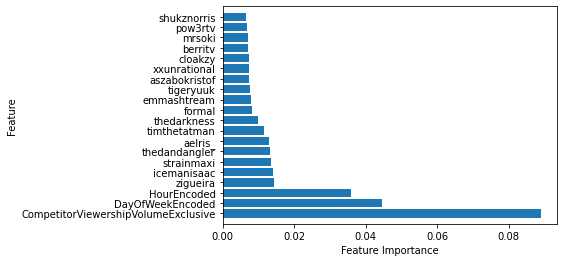

Classification Report if predicted all Medium
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.56      0.72       768
           2       0.00      0.00      0.00         0

    accuracy                           0.56       768
   macro avg       0.33      0.19      0.24       768
weighted avg       1.00      0.56      0.72       768



C:\Users\leesc\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
from sklearn.ensemble import RandomForestClassifier
X = target_streamer_data[shared_viewership + extra_features]
y = target_streamer_data['Target']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42, shuffle=False)

from sklearn.metrics import classification_report
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1) #max_depth=depth, n_estimators=est)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
#acc.append(accuracy_score(preds, y_test))

print(classification_report(preds, y_test))

plot_feature_importances(clf)
plt.show()

print('Classification Report if predicted all Medium')
#compared to predicting all medium's
print(classification_report([1]*len(preds), y_test))

SVD did not converge in Linear Least Squares
RMSE
6212.343372681786


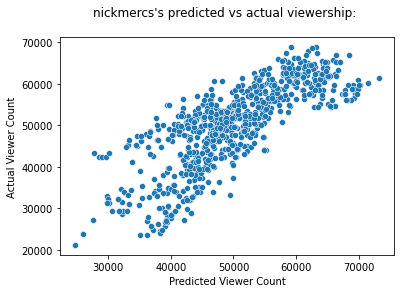

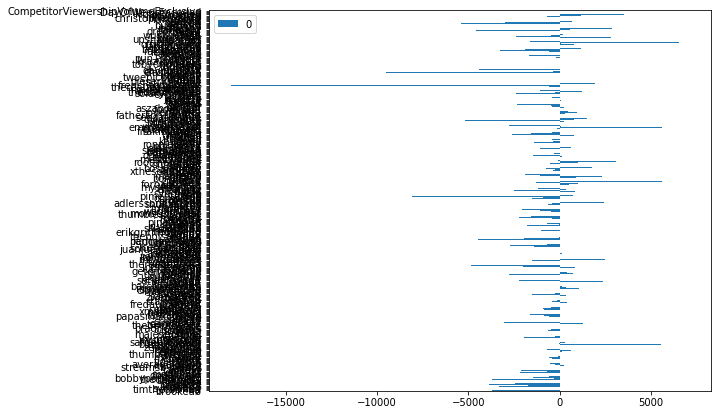

In [22]:
while True:
    try:
        #Linear Regression
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.linear_model import LinearRegression, Ridge, Lasso
        from sklearn.metrics import mean_squared_error
        from sklearn.preprocessing import MinMaxScaler, StandardScaler
        X = target_streamer_data[shared_viewership + extra_features]
        y = target_streamer_data['ViewerCount']


        from sklearn.model_selection import train_test_split
        #mms = MinMaxScaler()
        #mms.fit(X[X.columns[-3:]])
        #scaled_cols = mms.transform(X[X.columns[-3:]])
        #X[X.columns[-3:]] = scaled_cols
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42,shuffle=False)

        lm = LinearRegression() #max_depth=depth, n_estimators=est)
        lm.fit(X_train, y_train)
        preds = lm.predict(X_test)
        #acc.append(accuracy_score(preds, y_test))

        print('RMSE')
        print(np.sqrt(mean_squared_error(preds, y_test)))

        sns.scatterplot(x=preds,y=y_test)
        plt.ylabel('Actual Viewer Count')
        plt.xlabel('Predicted Viewer Count')
        plt.title(f'{target_streamer}\'s predicted vs actual viewership: \n')
        plt.show()

        coeff = {}
        for i, co in enumerate(lm.coef_):
            if co != 0:
                coeff[X.columns[i]] = [co]

        pd.DataFrame(coeff).transpose().plot(kind='barh', figsize=(9, 7))
        break
    except Exception as e:
        print(e)
        pass

C:\Users\leesc\miniconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.43638e-17): result may not be accurate.
  overwrite_a=True).T


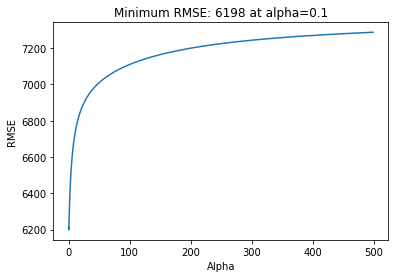

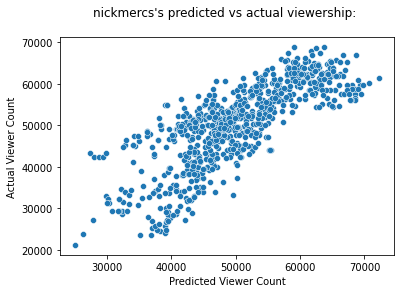

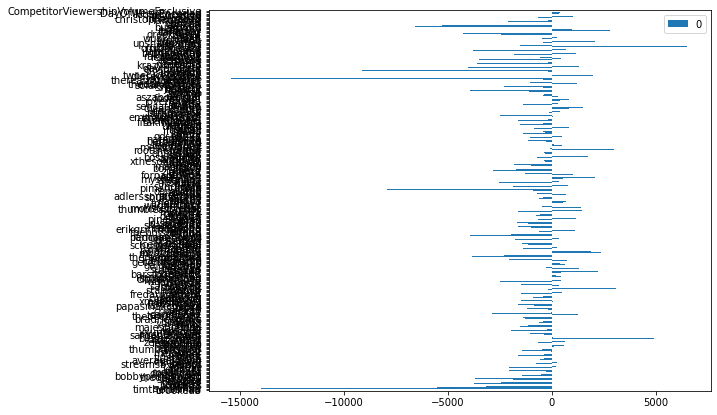

In [23]:
#RIDGE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
while True:
    try:

        rmse = []
        alpha_ls = []
        check_alpha = [.0001,.001,.01,.1] + list(np.arange(1,500,1))
        for alph in check_alpha:
            X = target_streamer_data[shared_viewership + extra_features]
            y = target_streamer_data['ViewerCount']

            X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, shuffle=False)

            alpha_ls.append(alph)
            lm = Ridge(alpha=alph) #increase alpha pushes coefficients towards 0
            lm.fit(X_train, y_train)
            preds = lm.predict(X_test)
            #acc.append(accuracy_score(preds, y_test))
            rmse.append(np.sqrt(mean_squared_error(preds, y_test)))

        val, idx = min((val, idx) for (idx, val) in enumerate(rmse))
        plt.plot(alpha_ls,rmse)
        plt.xlabel('Alpha')
        plt.ylabel('RMSE')
        plt.title(f'Minimum RMSE: {int(val)} at alpha={check_alpha[idx]}')
        plt.show()

        lm = Ridge(alpha=check_alpha[idx]) #increase alpha pushes coefficients towards 0
        lm.fit(X_train, y_train)
        preds = lm.predict(X_test)
        #acc.append(accuracy_score(preds, y_test))

        rmse.append(np.sqrt(mean_squared_error(preds, y_test)))

        sns.scatterplot(x=preds,y=y_test)
        plt.ylabel('Actual Viewer Count')
        plt.xlabel('Predicted Viewer Count')
        plt.title(f'{target_streamer}\'s predicted vs actual viewership: \n')
        plt.show()

        coeff = {}
        for i, co in enumerate(lm.coef_):
            if co != 0:
                coeff[X.columns[i]] = [co]

        pd.DataFrame(coeff).transpose().plot(kind='barh', figsize=(9, 7))
        break
    except Exception as e:
        print(e)
        pass

C:\Users\leesc\miniconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\leesc\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\leesc\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2673492904.325254, tolerance: 16006879.522163002
  positive)


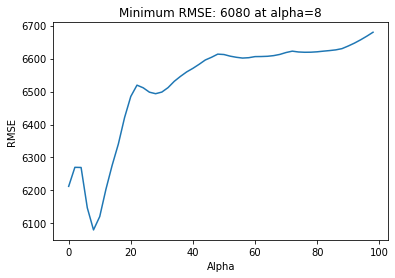

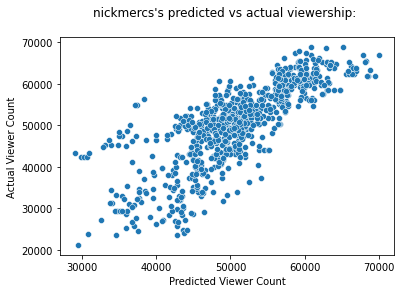

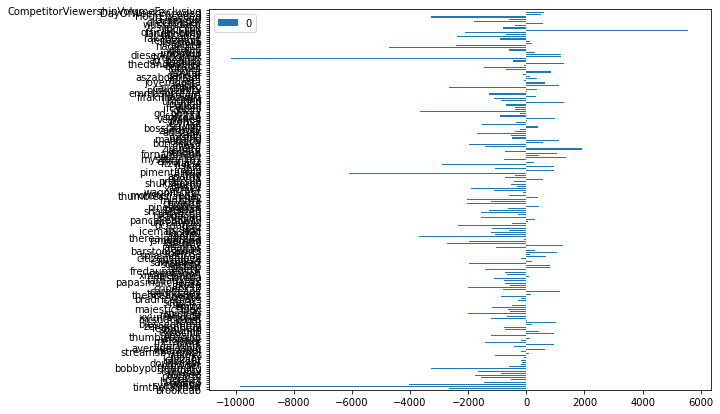

In [24]:
#Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
while True:
    try:
        rmse = []
        for alph in np.arange(0,100,2):
            X = target_streamer_data[shared_viewership + extra_features]
            y = target_streamer_data['ViewerCount']

            X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, shuffle=False)

            lm = Lasso(alpha=alph,max_iter=1000) #increase alpha pushes coefficients towards 0
            lm.fit(X_train, y_train)
            preds = lm.predict(X_test)
            #acc.append(accuracy_score(preds, y_test))

            rmse.append(np.sqrt(mean_squared_error(preds, y_test)))

        val, idx = min((val, idx) for (idx, val) in enumerate(rmse))
        plt.plot(list(np.arange(0,100,2)),rmse)
        plt.xlabel('Alpha')
        plt.ylabel('RMSE')
        plt.title(f'Minimum RMSE: {int(val)} at alpha={np.arange(0,100,2)[idx]}')
        plt.show()

        lm = Lasso(alpha=np.arange(0,200,2)[idx]) #increase alpha pushes coefficients towards 0
        lm.fit(X_train, y_train)
        preds = lm.predict(X_test)
        #acc.append(accuracy_score(preds, y_test))

        rmse.append(np.sqrt(mean_squared_error(preds, y_test)))

        sns.scatterplot(x=preds,y=y_test)
        plt.ylabel('Actual Viewer Count')
        plt.xlabel('Predicted Viewer Count')
        plt.title(f'{target_streamer}\'s predicted vs actual viewership: \n')
        plt.show()

        coeff = {}
        for i, co in enumerate(lm.coef_):
            if co != 0:
                coeff[X.columns[i]] = [co]

        pd.DataFrame(coeff).transpose().plot(kind='barh', figsize=(9, 7))
        break
    except Exception as e:
        print(e)
        break

RMSE
8718.233570377484


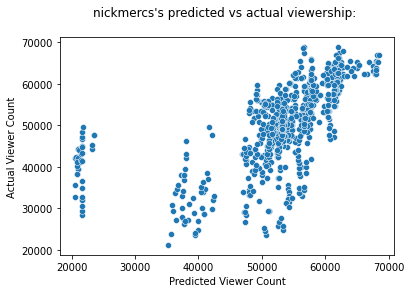

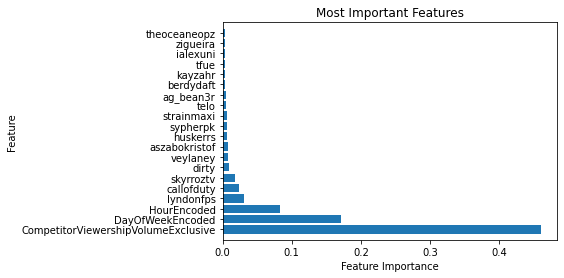

In [25]:
#Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
X = target_streamer_data[shared_viewership + extra_features]
y = target_streamer_data['ViewerCount']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42,shuffle=False)

rfreg = RandomForestRegressor(n_estimators=1000, n_jobs=-1) #max_depth=depth, n_estimators=est)
rfreg.fit(X_train, y_train)
preds = rfreg.predict(X_test)

print('RMSE')
print(np.sqrt(mean_squared_error(preds, y_test)))

sns.scatterplot(x=preds,y=y_test)
plt.ylabel('Actual Viewer Count')
plt.xlabel('Predicted Viewer Count')
plt.title(f'{target_streamer}\'s predicted vs actual viewership: \n')
plt.show()

plot_feature_importances(rfreg)
plt.title('Most Important Features')
plt.show()

In [27]:
'''from sklearn.ensemble import GradientBoostingRegressor
X = target_streamer_data[shared_viewership + ['HourEncoded','DayOfWeekEncoded','CompetitorViewershipVolumeExclusive']]
y = target_streamer_data['ViewerCount']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

from sklearn.metrics import classification_report
gbr = GradientBoostingRegressor() #max_depth=depth, n_estimators=est)
gbr.fit(X_train, y_train)
preds = gbr.predict(X_test)
#acc.append(accuracy_score(preds, y_test))

print('RMSE')
print(np.sqrt(mean_squared_error(preds, y_test)))

sns.scatterplot(x=preds,y=y_test)
plt.show()

plot_feature_importances(gbr)
plt.show()'''

"from sklearn.ensemble import GradientBoostingRegressor\nX = target_streamer_data[shared_viewership + ['HourEncoded','DayOfWeekEncoded','CompetitorViewershipVolumeExclusive']]\ny = target_streamer_data['ViewerCount']\n\n\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)\n\nfrom sklearn.metrics import classification_report\ngbr = GradientBoostingRegressor() #max_depth=depth, n_estimators=est)\ngbr.fit(X_train, y_train)\npreds = gbr.predict(X_test)\n#acc.append(accuracy_score(preds, y_test))\n\nprint('RMSE')\nprint(np.sqrt(mean_squared_error(preds, y_test)))\n\nsns.scatterplot(x=preds,y=y_test)\nplt.show()\n\nplot_feature_importances(gbr)\nplt.show()"

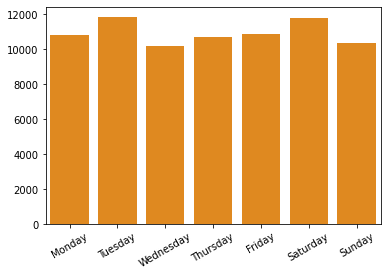

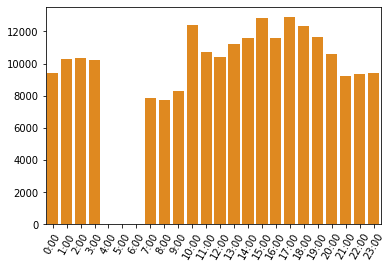

In [28]:
viewership_dayofweek = {}
for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
    viewership_dayofweek[day] = target_streamer_data[target_streamer_data['DayOfWeek'] == day]['ViewerCount'].mean()
ax = sns.barplot(x=list(viewership_dayofweek.keys()),y=list(viewership_dayofweek.values()),color='darkorange')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

viewership_hour = {}
for hour in np.arange(0,24,1):
    viewership_hour[hour] = target_streamer_data[target_streamer_data['Hour'] == hour]['ViewerCount'].mean()
ax = sns.barplot(x=[str(hr) + ':00' for hr in list(viewership_hour.keys())],y=list(viewership_hour.values()),color='darkorange')
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
plt.show()

In [29]:
'''live = []
not_live = []
for competitor in shared_viewership:
    #average while competitor is live
    live.append(target_streamer_data[target_streamer_data[competitor] == 1]['ViewerCount'].mean())
    
    #average while competitor is not live
    not_live.append(target_streamer_data[target_streamer_data[competitor] == 0]['ViewerCount'].mean())

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Not Live', x=shared_viewership, y=not_live),
    go.Bar(name='Live', x=shared_viewership, y=live)
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()'''

"live = []\nnot_live = []\nfor competitor in shared_viewership:\n    #average while competitor is live\n    live.append(target_streamer_data[target_streamer_data[competitor] == 1]['ViewerCount'].mean())\n    \n    #average while competitor is not live\n    not_live.append(target_streamer_data[target_streamer_data[competitor] == 0]['ViewerCount'].mean())\n\nimport plotly.graph_objects as go\n\nfig = go.Figure(data=[\n    go.Bar(name='Not Live', x=shared_viewership, y=not_live),\n    go.Bar(name='Live', x=shared_viewership, y=live)\n])\n# Change the bar mode\nfig.update_layout(barmode='group')\nfig.show()"